In [2]:
from PIL import Image #用于处理图片的pillow库
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
'''图像处理,使用中值滤波去噪'''
# 输入文件夹路径
input_folder = 'data/image'
# 输出文件夹路径
output_folder = 'data/new_image'

In [5]:
# 获取输入文件夹中的所有图像文件
image_files = os.listdir(input_folder)

In [6]:
for file in image_files:
    
    #获取图片完整路径
    input_path = os.path.join(input_folder, file)
    
    # 读取图片
    image = cv2.imread(input_path)

    # 使用中值滤波
    denoised_image = cv2.medianBlur(image, ksize=3)

    # 获取文件名（包括扩展名）
    file_name = file.split('/')[-1]

    # 保存去噪后的图像
    output_file = output_folder +'/'+ file_name
    cv2.imwrite(output_file, denoised_image)

In [7]:
#处理后对比,对比三张处理的结果
# 图片文件列表
image_files = []
for i in range(30,33):
    image_files.append(input_folder+"/{}.jpg".format(i+1))
    image_files.append(output_folder+"/{}.jpg".format(i+1))

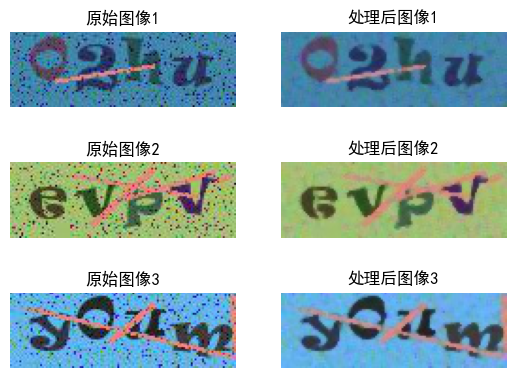

In [8]:
#批量显示
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.axis('off')
    image=Image.open(image_files[i])
    plt.imshow(image)
    if((i+1)%2==1):
        plt.title("原始图像{}".format(int(i/2+1)))
    else:
        plt.title("处理后图像{}".format(int(i/2+1)))
plt.show()

In [9]:
'''数据处理，制作训练集'''
image = Image.open(image_files[0])
image.size

(120, 40)

In [10]:
#得知每个图片大小为40*120 
# 定义字符集合
source = [str(i) for i in range(0, 10)]  # 数字 0-9
source += [chr(i) for i in range(97, 97+26)]  # 小写字母 a-z
source += [chr(i) for i in range(65, 65+26)]  # 大写字母 A-Z
alphabet = ''.join(source)

In [11]:
# 定义图像加载器，将图像以RGB格式加载
def img_loader(img_path):
    img = Image.open(img_path)
    return img.convert('RGB')
# 创建数据集函数
def make_dataset(data_path, alphabet, num_class, num_char):
    # 读取图像文件列表并排序
    img = os.listdir(data_path)
    img.sort(key=lambda x: int(x.split('.')[0]))

    # 读取标签数据
    df = pd.read_csv("./data/train_label.csv")
    
    samples = []
    for imgname in img:
        i = int(imgname.split(".")[0])  # 获取图像的序号
        imgpath = os.path.join(data_path, imgname)  # 图像路径
        label = df['label'][i-1]  # 对应标签
        
        target = []
        for char in label:  # 遍历标签中的每个字符
            vec = [0] * 62  # 初始化一个长度为62的零向量
            vec[alphabet.find(char)] = 1  # 将字符所在位置的值设为1
            target += vec  # 将向量添加到目标列表中
        samples.append((imgpath, target))  # 添加图像路径和目标列表到样本列表中
    return samples

In [12]:
# 定义自定义数据集类
class CaptchaData(Dataset):
    def __init__(self, data_path, num_class=62, num_char=4,
                 transform=None, target_transform=None, alphabet=alphabet):
        super(Dataset, self).__init__()
        self.data_path = data_path
        self.num_class = num_class
        self.num_char = num_char
        self.transform = transform
        self.target_transform = target_transform
        self.alphabet = alphabet
        self.samples = make_dataset(self.data_path, self.alphabet, 
                                    self.num_class, self.num_char)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path, target = self.samples[index]
        img = img_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, torch.Tensor(target)

In [13]:
#创建数据集
transforms = Compose([ToTensor()])
train_dataset = CaptchaData('./data/new_image/', transform=transforms)

In [21]:
#划分训练集与测试集
#训练集大小
train_size = int(len(train_dataset)*0.8)
#测试集大小
test_size = int(len(train_dataset)-train_size)
#随机分配测试集序号和训练集序号
train_dataset,test_dataset = torch.utils.data.random_split(train_dataset,[train_size,test_size])
#训练集,池大小64
train_data_loader = DataLoader(train_dataset, batch_size=64, num_workers=0,shuffle=True, drop_last=True)
#测试集，池大小64
test_data_loader = DataLoader(test_dataset, batch_size=64,num_workers=0, shuffle=True, drop_last=True)

In [15]:
'''构造神经网络模型'''
# 定义卷积神经网络模型
class CNN(nn.Module):
    def __init__(self, num_class=62, num_char=4):
        super(CNN, self).__init__()
        self.num_class = num_class
        self.num_char = num_char
        
        # 定义卷积层和池化层
        self.conv = nn.Sequential(
            #batch*3*120*40
            # 输入通道数为3，输出通道数为16，卷积核大小为3x3，填充为1，
            nn.Conv2d(3, 16, 3, padding=(1, 1)),
            nn.MaxPool2d(2, 2),  # 使用2x2的最大池化层，将特征图尺寸缩小为原来的一半
            nn.BatchNorm2d(16),  # 批归一化层，用于加速网络收敛和提高模型性能
            nn.ReLU(),
            #batch*16*60*20
            # 输入通道数为16，输出通道数为64，卷积核大小为3x3，填充为1，
            nn.Conv2d(16, 64, 3, padding=(1, 1)),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #batch*64*30*10
            # 输入通道数为64，输出通道数为512，卷积核大小为3x3，填充为1，
            nn.Conv2d(64, 512, 3, padding=(1, 1)),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #batch*512*15*5
            # 输入通道数为512，输出通道数为512，卷积核大小为3x3，填充为1，
            nn.Conv2d(512, 512, 3, padding=(1, 1)),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU()
            #batch*512*7*2
        )
        
        # 定义全连接层
        # 输入特征数量为512*7*2，输出特征数量为num_class*num_char
        self.fc = nn.Linear(512*7*2, self.num_class*self.num_char)
        #batch*62*4
        
    def forward(self, x):
        x = self.conv(x)  # 前向传播过程中的卷积操作
        x = x.view(-1, 512*7*2)  # 将特征图展平成向量
        x = self.fc(x)  # 应用全连接层
        return x

In [22]:
#初始化模型
cnn = CNN()

In [17]:
cnn

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Batch

In [18]:
'''定义训练函数'''
# 计算准确率函数
def calculat_acc(output, target):
    output, target = output.view(-1, 62), target.view(-1, 62)  # 将预测结果和目标标签展平成二维张量，每一行表示一个样本的预测结果或目标标签
    output = nn.functional.softmax(output, dim=1)  # 对预测结果应用softmax函数，得到每个类别的概率分布
    output = torch.argmax(output, dim=1)  # 取概率最高的类别作为最终的预测结果
    target = torch.argmax(target, dim=1)  # 将目标标签由one-hot编码转换为类别索引
    output, target = output.view(-1, 4), target.view(-1, 4)  # 将预测结果和目标标签重新恢复成二维张量
    
    correct_list = []
    for i, j in zip(target, output):  # 遍历每个样本的目标标签和预测结果
        if torch.equal(i, j):  # 判断预测结果是否与目标标签相等
            correct_list.append(1)  # 相等则预测正确，添加1到正确列表
        else:
            correct_list.append(0)  # 不相等则预测错误，添加0到正确列表
    
    acc = sum(correct_list) / len(correct_list)  # 计算准确率，正确个数除以总样本数
    return acc


In [19]:
# 训练函数
def train():
    base_lr = 0.001 #学习率
    max_epoch = 50  #最大训练轮数
    model_path = './checkpoints/modeltest.pth' #模型保存路径
    restor = False
    if torch.cuda.is_available():
        cnn.cuda()  # 将模型移动到GPU上（若可用）
    if restor:
        cnn.load_state_dict(torch.load(model_path))  # 加载预训练的模型参数（如果存在）
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=base_lr)  # 定义优化器
    criterion = nn.MultiLabelSoftMarginLoss()  # 定义损失函数
    
    train_loss_mean = []
    train_acc_mean = []
    test_loss_mean = []
    test_acc_mean = []
    
    for epoch in range(max_epoch):
        start_ = time.time()  # 记录起始时间
        
        loss_history = []
        acc_history = []
        
        cnn.train()  # 设置模型为训练模式
        for img, target in train_data_loader:  # 遍历训练数据集
            img = Variable(img)
            target = Variable(target)
            if torch.cuda.is_available():
                img = img.cuda()
                target = target.cuda()
            output = cnn(img)  # 前向传播
            loss = criterion(output, target)  # 计算损失函数
            optimizer.zero_grad()  # 梯度清零
            loss.backward()  # 反向传播
            optimizer.step()  # 更新模型参数
            acc = calculat_acc(output, target)  # 计算准确率
            acc_history.append(float(acc))
            loss_history.append(float(loss))
        #计算本轮训练集平均损失值和准确率    
        train_loss = torch.mean(torch.Tensor(loss_history))#平均损失值
        train_acc =torch.mean(torch.Tensor(acc_history))*100#平均准确率
        #平均损失值和准确率 加入列表以便后期绘图
        train_loss_mean.append(train_loss)
        train_acc_mean.append(train_acc)
        
        #对测试集进行预测并计算准确率和训练时间
        loss_history = []
        acc_history = []
        cnn.eval()
        for img, target in test_data_loader:
            img = Variable(img)
            target = Variable(target)
            if torch.cuda.is_available():
                img = img.cuda()
                target = target.cuda()
            output = cnn(img)

            acc = calculat_acc(output, target)
            acc_history.append(float(acc))
            loss_history.append(float(loss))
        #计算本轮测试集平均损失值和准确率  
        test_loss = torch.mean(torch.tensor(loss_history))
        test_acc =torch.mean(torch.tensor(acc_history))*100
        test_loss_mean.append(test_loss)
        test_acc_mean.append(test_acc)
        #保存模型
        torch.save(cnn.state_dict(), model_path) 
        #输出时间、训练集损失值、训练集准确率和测试机准确率
        print("轮数{:2d}：用时 {:.2f} s|训练集损失值 {:.6f}|训练集准确率 {:2.4f}%|测试集损失值 {:.6f}|测试集准确率 {:2.4f}%".format(
        epoch+1,time.time()-start_,train_loss,train_acc,test_loss,test_acc))
    return train_loss_mean,train_acc_mean,test_loss_mean,test_acc_mean

In [23]:
"""开始训练模型"""
train_loss_mean,train_acc_mean,test_loss_mean,test_acc_mean=train()

轮数 1：用时 4.79 s|训练集损失值 0.123751|训练集准确率 0.0000%|测试集损失值 0.087179|测试集准确率 0.0000%
轮数 2：用时 4.75 s|训练集损失值 0.085199|训练集准确率 0.0000%|测试集损失值 0.082416|测试集准确率 0.0000%
轮数 3：用时 4.78 s|训练集损失值 0.079514|训练集准确率 0.0000%|测试集损失值 0.074070|测试集准确率 0.0000%
轮数 4：用时 4.73 s|训练集损失值 0.054723|训练集准确率 4.3125%|测试集损失值 0.037494|测试集准确率 12.5000%
轮数 5：用时 4.73 s|训练集损失值 0.020145|训练集准确率 63.9687%|测试集损失值 0.013648|测试集准确率 63.6719%
轮数 6：用时 4.71 s|训练集损失值 0.006219|训练集准确率 96.2188%|测试集损失值 0.005338|测试集准确率 82.0312%
轮数 7：用时 4.72 s|训练集损失值 0.002549|训练集准确率 99.2188%|测试集损失值 0.002424|测试集准确率 88.1510%
轮数 8：用时 4.84 s|训练集损失值 0.001372|训练集准确率 99.8750%|测试集损失值 0.001104|测试集准确率 89.7135%
轮数 9：用时 4.78 s|训练集损失值 0.000784|训练集准确率 100.0000%|测试集损失值 0.000691|测试集准确率 90.2344%
轮数10：用时 4.81 s|训练集损失值 0.000543|训练集准确率 100.0000%|测试集损失值 0.000636|测试集准确率 91.7969%
轮数11：用时 4.88 s|训练集损失值 0.000403|训练集准确率 100.0000%|测试集损失值 0.000400|测试集准确率 92.1875%
轮数12：用时 4.83 s|训练集损失值 0.000320|训练集准确率 100.0000%|测试集损失值 0.000310|测试集准确率 92.3177%
轮数13：用时 4.74 s|训练集损失值 0.000261|训练集准确率 100.0000%|测试集损失值 

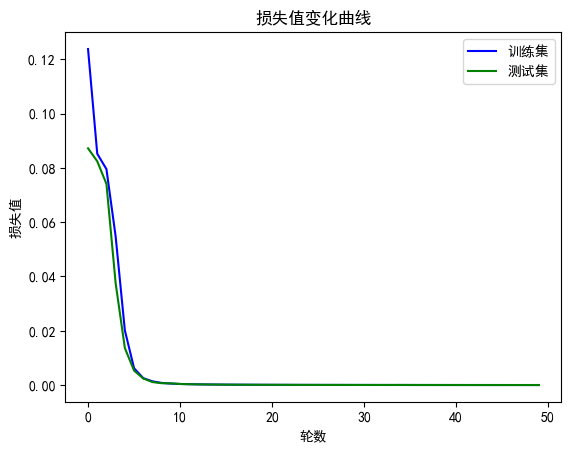

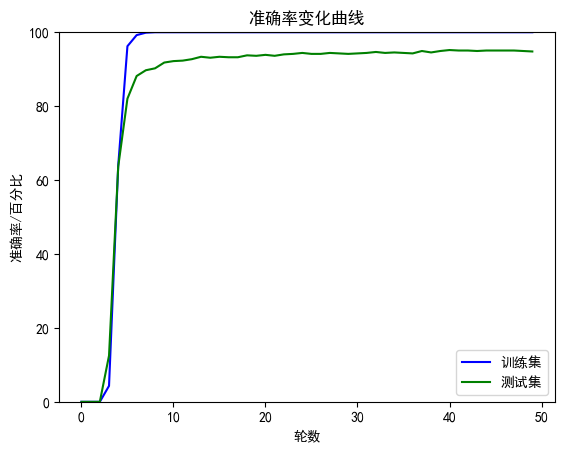

In [24]:
# 设置RC参数字体，让其支持中文
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

#绘制损失变化曲线
plt.plot(train_loss_mean, "b", label="训练集")
plt.plot(test_loss_mean, "g", label="测试集")
plt.legend()
plt.xlabel("轮数")
plt.ylabel("损失值")
plt.title("损失值变化曲线")
plt.savefig("损失值变化曲线.png")
plt.show()
#绘制准确率变化曲线
plt.plot(train_acc_mean, "b", label="训练集")
plt.plot(test_acc_mean, "g", label="测试集")
plt.legend()
plt.xlabel("轮数")
plt.ylabel("准确率/百分比")
plt.title("准确率变化曲线")
plt.ylim(0, 100)
plt.savefig("准确率变化曲线.png")
plt.show()

In [183]:
df = pd.read_csv("./data/train_label.csv")


In [184]:
df

,ID,label
0,1.jpg,4Jy3
1,2.jpg,P6Bf
2,3.jpg,vJlD
3,4.jpg,1Mnb
4,5.jpg,B6UB
...,...,...
4995,4996.jpg,DmX7
4996,4997.jpg,KFin
4997,4998.jpg,bSdV
4998,4999.jpg,QLuH
